In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates

In [2]:
def parse_data(s):
    s = s.split("T")[0]
    mese = s.split("-")[1]
    giorno = s.split("-")[2]
    
    return giorno + "/" + str(int(mese))

def min_max_normalization( arr):
    minv= min(arr)
    maxv= max(arr)
    arr = [(x-minv)/(maxv-minv) for x in arr]
    return arr

def create_figure():
    fig = plt.figure()
    fig.set_size_inches(20, 5)
    ax = fig.add_axes([0.1, 0.2, 0.8, 0.9]) 
    plt.xticks(rotation=45)
    return ax

def hide_ticks(ax, factor):
    for label in ax.xaxis.get_ticklabels()[::factor]:
        label.set_visible(False)  

dati = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')

giorni = list(map(parse_data, dati["data"].values))
percentages = [ str(x) + '%' for x in np.array([0.0, 25.0, 50.0, 75.0, 100.0])]

# nuovi tamponi giornalieri
numero_tamponi = dati["tamponi"].values
delta_tamponi = [numero_tamponi[0]]
for g in range(len(numero_tamponi) - 1):
    delta_tamponi += [numero_tamponi[g+1] - numero_tamponi[g]]
  
# nuovi casi
totale_casi = dati["totale_casi"].values
delta_totale_casi = [totale_casi[0]]
for g in range(len(numero_tamponi) - 1):
    delta_totale_casi += [totale_casi[g+1] - totale_casi[g]]
    
# percentuale nuovi_positivi/nuovi_tamponi
div = lambda x: x[0]/x[1] if 0<(x[0]/x[1])<1 else None
ratio_nuovi_pos_nuovi_tamp = list(map(div, list(zip(delta_totale_casi, delta_tamponi))))

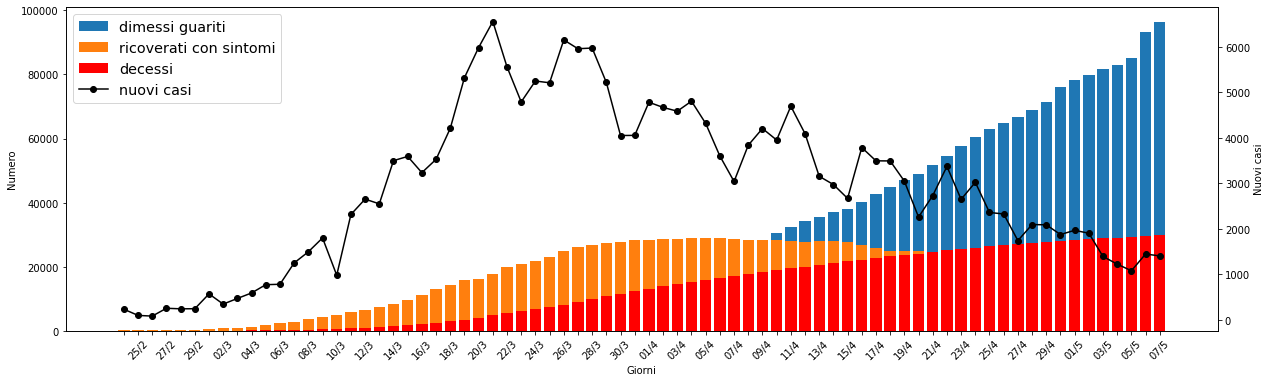

In [3]:
ax = create_figure()

ax.set_xlabel('Giorni')
ax.set_ylabel('Numero')

bar1 = ax.bar(giorni, dati['dimessi_guariti'], label='dimessi guariti')
bar2 = ax.bar(giorni, dati['ricoverati_con_sintomi'], label='ricoverati con sintomi')
bar3 = ax.bar(giorni, dati['deceduti'], label='decessi', color='r')

hide_ticks(ax, 2)

ax2 = ax.twinx()
line1 = ax2.plot(giorni, delta_totale_casi, label="nuovi casi", color="k", marker="o", linestyle="-")
ax2.set_ylabel('Nuovi casi')

arr = [bar1, bar2, bar3]+line1
labs = [a.get_label() for a in arr]
ax.legend(arr, labs, fontsize='x-large')

plt.show()

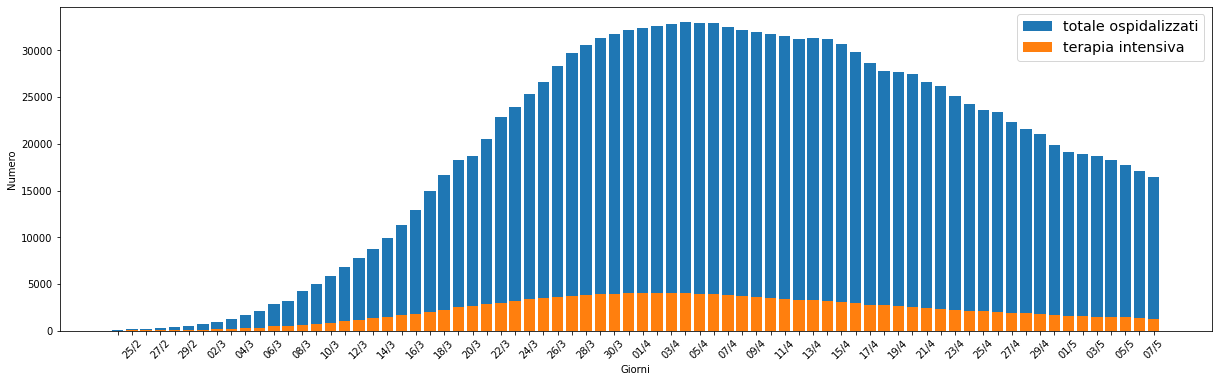

In [4]:
ax = create_figure()

ax.set_xlabel('Giorni')
ax.set_ylabel('Numero')
ax.bar(giorni, dati['totale_ospedalizzati'], label='totale ospidalizzati')
ax.bar(giorni, dati['terapia_intensiva'], label='terapia intensiva')
hide_ticks(ax, 2)
ax.legend(fontsize='x-large')

plt.show()

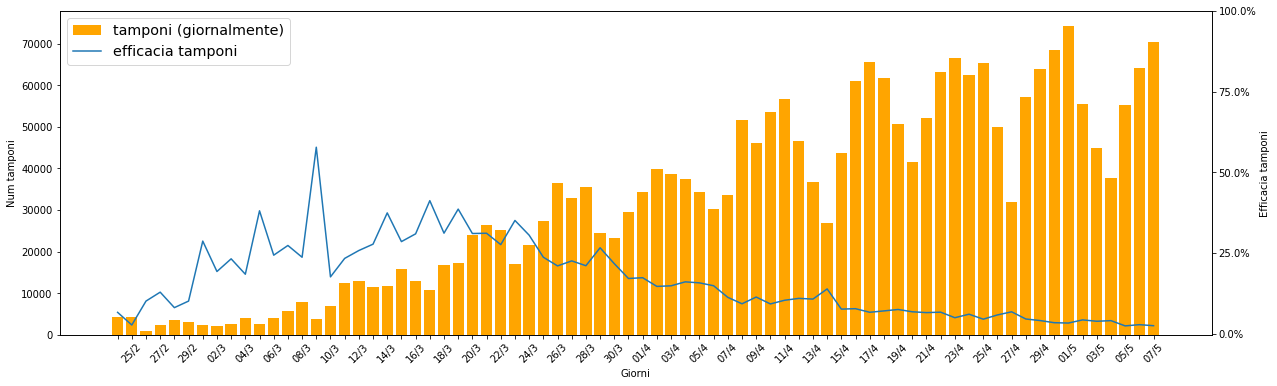

In [5]:
ax = create_figure()

ax.set_xlabel('Giorni')
ax.set_ylabel('Percentuale')

bar = ax.bar(giorni, delta_tamponi, label="tamponi (giornalmente)", color="orange")
hide_ticks(ax, 2)

# double y axis
ax2 = ax.twinx()
line_positivi = ax2.plot(giorni, ratio_nuovi_pos_nuovi_tamp, label="efficacia tamponi")
ax.set_ylabel('Num tamponi')

ax2.set_yticks(np.arange(0, 1, step=0.20))
ax2.set_yticklabels(percentages)
ax2.set_ylabel('Efficacia tamponi')

arr = [bar]+line_positivi
labs = [a.get_label() for a in arr]
ax.legend(arr, labs, fontsize='x-large')

plt.show()